In [1]:
# Re-declare everything needed to rebuild the model
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, GraphNorm
from minisom import MiniSom
import torch

class GNNEncoder(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=64):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels)
        self.gat3 = GATConv(hidden_channels, hidden_channels)
        self.norm = GraphNorm(hidden_channels)
        self.dropout = nn.Dropout(0.25)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.leaky_relu(self.gat1(x, edge_index))
        x = self.norm(x, batch)
        x = self.dropout(x)
        x = F.leaky_relu(self.gat2(x, edge_index))
        x = x + self.gat3(x, edge_index)
        x = global_mean_pool(x, batch)
        return x

class SOMSoftLayer(nn.Module):
    def __init__(self, m, n, dim):
        super().__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.som = MiniSom(m, n, dim, sigma=0.7, learning_rate=0.3)
        self.initialized = False

    def forward(self, x):
        x_np = x.detach().cpu().numpy()
        if not self.initialized:
            self.som.random_weights_init(x_np)
            self.som.train_batch(x_np, 1000)
            self.initialized = True
        responses = np.array([
            self.som.activation_response([v])[0].flatten()
            for v in x_np
        ])
        return torch.from_numpy(responses).float().to(x.device)

class MultiPropertyPredictor(nn.Module):
    def __init__(self, num_properties=4):
        super().__init__()
        self.encoder = GNNEncoder()
        self.som = SOMSoftLayer(3, 3, 64)
        self.som_output_dim = None
        self.num_properties = num_properties
        self.regressor = None

    def forward(self, data):
        x = self.encoder(data)
        som_out = self.som(x)

        if self.som_output_dim is None:
            self.som_output_dim = som_out.shape[1]
            self.regressor = nn.Sequential(
                nn.Linear(64 + self.som_output_dim, 64),
                nn.ReLU(),
                nn.Linear(64, self.num_properties)
            )
            self.regressor.to(x.device)

        combined = torch.cat([x, som_out], dim=1)
        return self.regressor(combined)


In [5]:
from rdkit import Chem
import torch
from torch_geometric.data import Data, Batch
import numpy as np

# Same atom_features function as before
def atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        int(atom.GetIsAromatic()),
        atom.GetTotalNumHs(includeNeighbors=True),
        atom.GetMass(),
        atom.GetExplicitValence(),
        atom.GetImplicitValence()
    ]

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    x = torch.tensor([atom_features(a) for a in atoms], dtype=torch.float)
    edge_index = []
    for bond in bonds:
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

# Sample SMILES for a small molecule (e.g., ethanol)
dummy_graph = smiles_to_graph("CCO")
dummy_batch = Batch.from_data_list([dummy_graph])
model = MultiPropertyPredictor(num_properties=4)
# model = MultiPropertyPredictor(num_properties=len(property_indices))
# Forward to initialize

_ = model(dummy_batch)

# Load weights now
model.load_state_dict(torch.load("saved_model/som_gnn_multitarget.pth"))
model.eval()

print("✅ Model loaded and ready for prediction!")


✅ Model loaded and ready for prediction!


In [7]:
import deepchem as dc
tasks, datasets, _ = dc.molnet.load_qm9(featurizer='GraphConv')
train_dataset, _, _ = datasets

property_indices = [1, 2, 9, 11]  # alpha, HOMO, H, Cv
smiles_list = []
y_values = []

for _, y, _, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
    smiles_list.append(ids[0])
    y_values.append(y[0][property_indices])
    
y_values = np.array(y_values)

# Reuse your smiles_to_graph() function from before
graphs = [smiles_to_graph(s) for s in smiles_list]


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [18]:
def predict_properties(smiles, model, scalers, property_names):
    model.eval()
    
    # Convert SMILES to graph
    graph = smiles_to_graph(smiles)
    batch = Batch.from_data_list([graph])
    
    with torch.no_grad():
        pred_scaled = model(batch)[0].cpu().numpy()
    
    # Inverse transform each property
    predictions = {}
    for i, name in enumerate(property_names):
        pred = scalers[i].inverse_transform([[pred_scaled[i]]])[0][0]
        predictions[name] = pred
    
    return predictions


In [20]:
import joblib

property_names = ['alpha', 'HOMO', 'H', 'Cv']
scalers = [joblib.load(f"saved_model/scaler_{name}.pkl") for name in property_names]


In [28]:
result = predict_properties("CCO", model, scalers, property_names)


In [30]:
print(result)

{'alpha': -0.7836720943451448, 'HOMO': -0.13373672962192357, 'H': 0.5640478134156185, 'Cv': -0.07359142601488376}


In [32]:
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [34]:
model.eval()
random_indices = random.sample(range(len(graphs)), 100)

predictions = {name: [] for name in property_names}
actuals = {name: [] for name in property_names}

with torch.no_grad():
    for i in random_indices:
        graph = graphs[i]
        batch_data = Batch.from_data_list([graph])
        pred_scaled = model(batch_data)[0].cpu().numpy()
        
        for j, name in enumerate(property_names):
            actual = y_values[i, j]
            pred = scalers[j].inverse_transform([[pred_scaled[j]]])[0][0]
            actuals[name].append(actual)
            predictions[name].append(pred)

# Evaluate and plot


In [36]:
# 10. Calculate metrics for each property
print("\n Performance Metrics for Each Property:")
for name in property_names:
    mae = mean_absolute_error(actuals[name], predictions[name])
    rmse = mean_squared_error(actuals[name], predictions[name], squared=False)
    r2 = r2_score(actuals[name], predictions[name])
    
    print(f"\n🔹 {name}:")
    print(f"   MAE: {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R² Score: {r2:.4f}")




 Performance Metrics for Each Property:

🔹 alpha:
   MAE: 0.7913
   RMSE: 1.0763
   R² Score: 0.1015

🔹 HOMO:
   MAE: 0.6482
   RMSE: 0.8443
   R² Score: 0.0964

🔹 H:
   MAE: 0.7926
   RMSE: 1.1094
   R² Score: 0.0619

🔹 Cv:
   MAE: 0.7989
   RMSE: 1.1094
   R² Score: 0.0618


C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

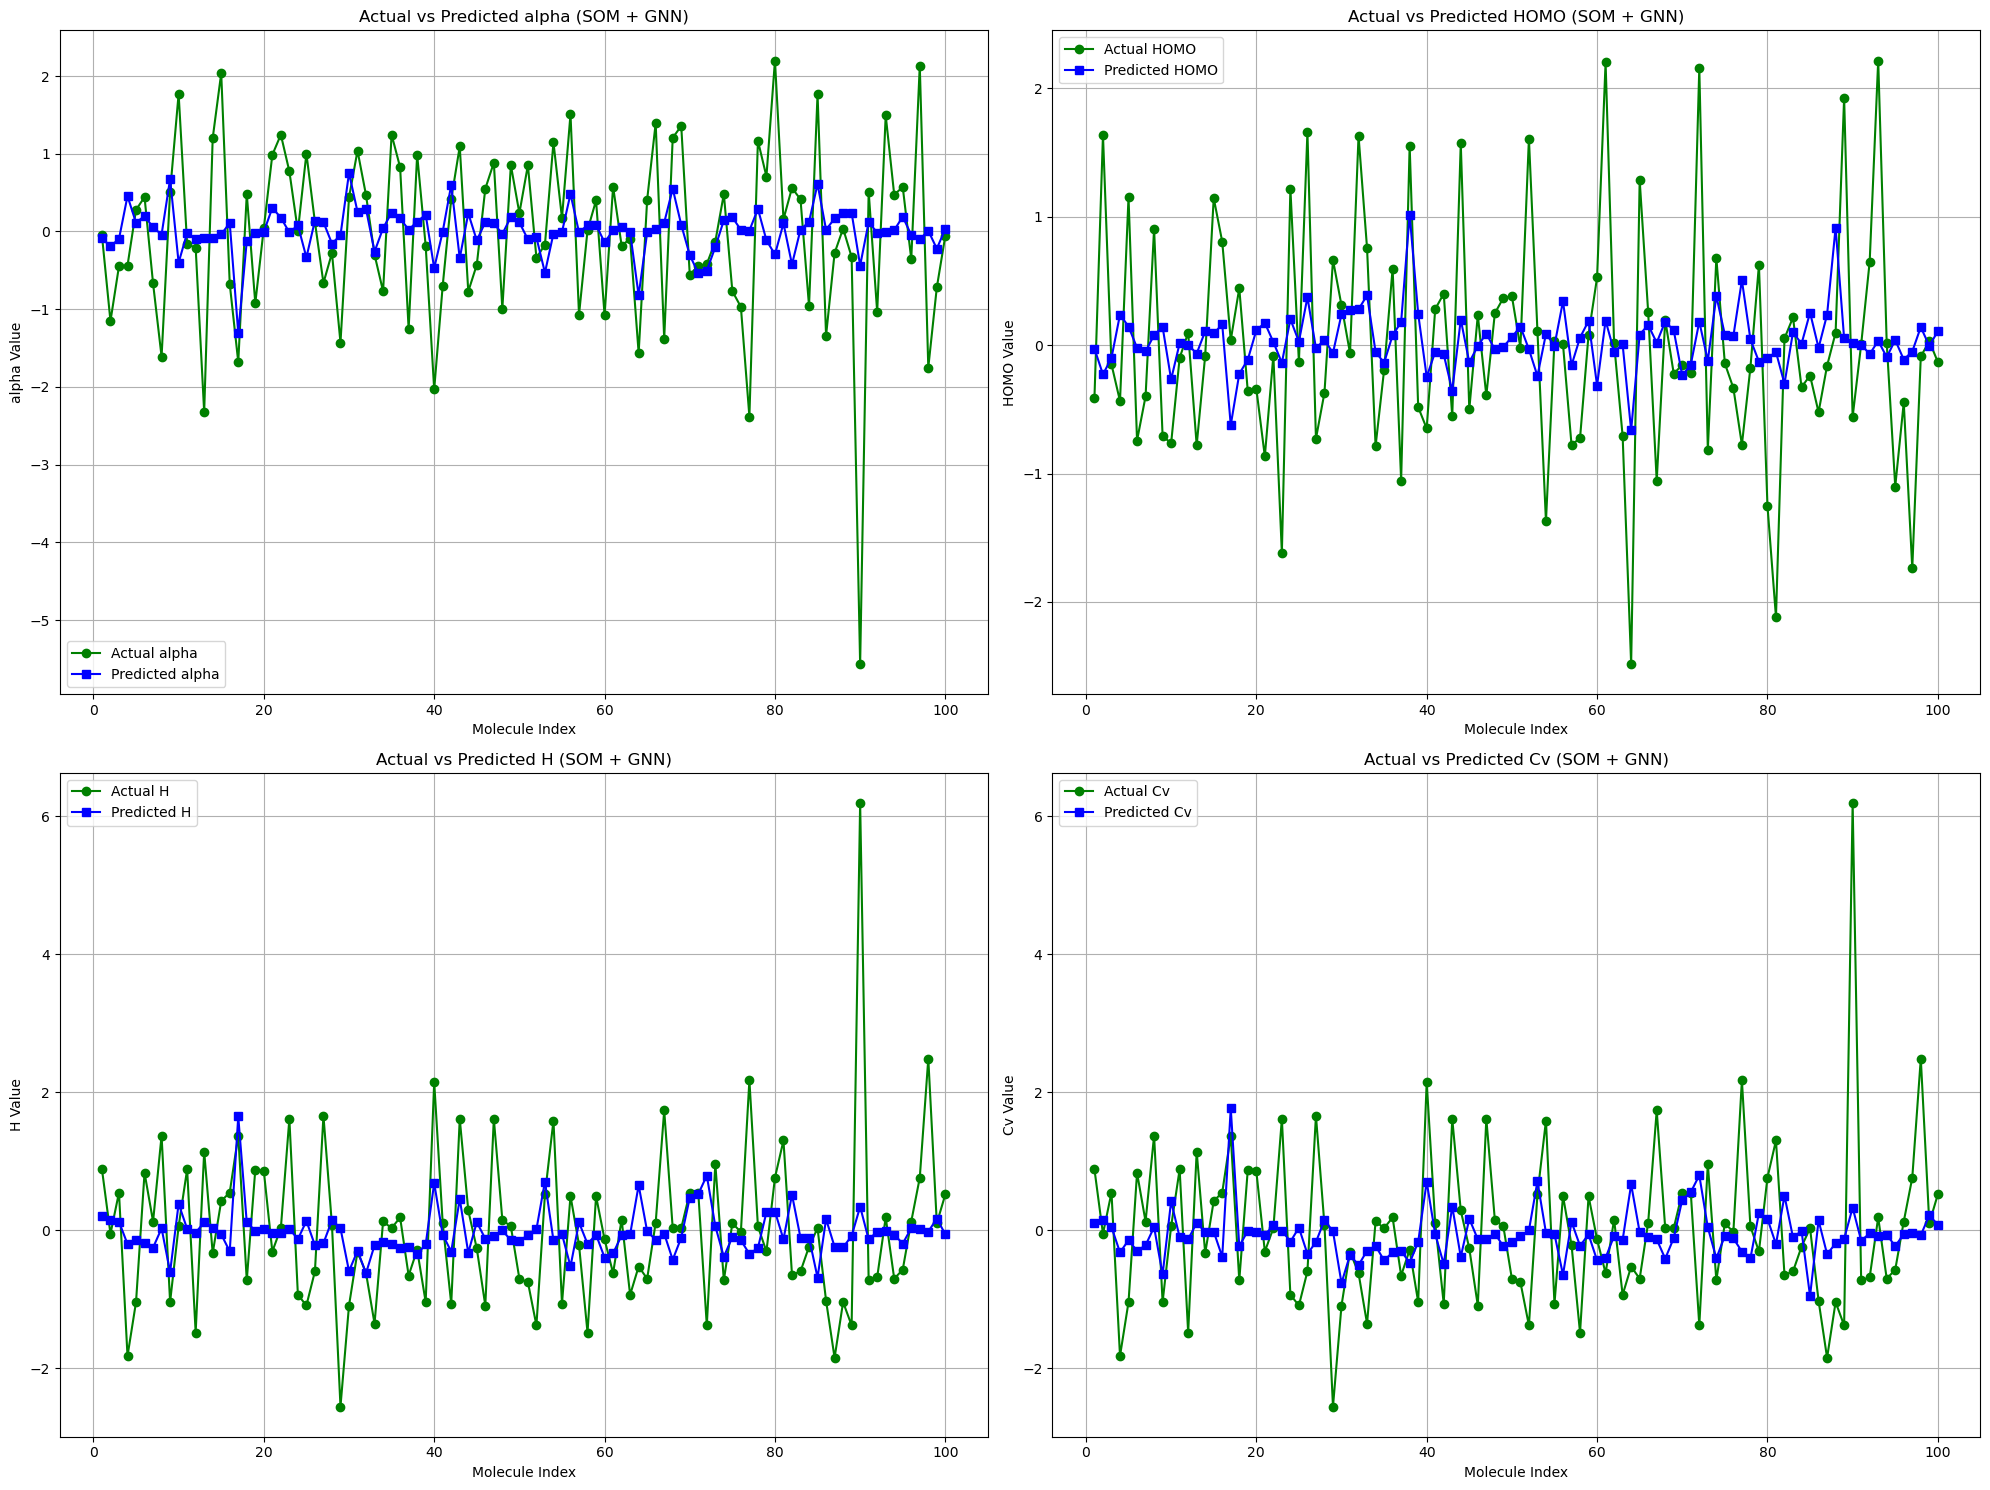

In [38]:
# 11. Plot results for each property
plt.figure(figsize=(20, 15))
for i, name in enumerate(property_names, 1):
    plt.subplot(2, 2, i)
    plt.plot(range(1, 101), actuals[name], label=f'Actual {name}', marker='o', color='green')
    plt.plot(range(1, 101), predictions[name], label=f'Predicted {name}', marker='s', color='blue')
    plt.xlabel("Molecule Index")
    plt.ylabel(f"{name} Value")
    plt.title(f"Actual vs Predicted {name} (SOM + GNN)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()